In [1]:
# Cargamos datos
import Loading_data 
from matplotlib import pyplot as plt    

COMUNIDAD_A_CONSIDERAR = 'Madrid'
comunidad = Loading_data.Get_Comunidad(COMUNIDAD_A_CONSIDERAR)
comunidad


,Lugar,Casos,Casos hoy absoluto,Casos hoy variacion respecto ayer,Casos hoy porcentaje,Fallecidos,Fallecidos hoy absoluto,Fallecidos hoy variacion respecto ayer,Fallecidos hoy porcentaje,Tasa Mortalidad,Curados,Curados hoy absoluto,Casos excluidos curados,Proporcion Curados / Casos,UCI,Hospitalizados
Fecha,,,,,,,,,,,,,,,,
2020-04-05,Madrid,37584,1335,-726,0.035520,4941,218,-22,0.044121,0.131466,16543,1181.0,21041,0.440161,1499,14551
2020-04-04,Madrid,36249,2061,28,0.056857,4723,240,-68,0.050815,0.130293,15362,1512.0,20887,0.423791,1498,14741
2020-04-03,Madrid,34188,2033,-282,0.059465,4483,308,-2,0.068704,0.131128,13850,1450.0,20338,0.405113,1506,15050
2020-04-02,Madrid,32155,2315,-16,0.071995,4175,310,48,0.074251,0.129840,12400,1573.0,19755,0.385632,1528,15227
2020-04-01,Madrid,29840,2331,-1088,0.078117,3865,262,51,0.067788,0.129524,10827,1497.0,19013,0.362835,1514,15227
2020-03-31,Madrid,27509,3419,2006,0.124287,3603,211,-99,0.058562,0.130975,9330,1029.0,18179,0.339162,1514,15140
2020-03-30,Madrid,24090,1413,256,0.058655,3392,310,-15,0.091392,0.140805,8301,810.0,15789,0.344583,1460,14917
2020-03-29,Madrid,22677,1157,-1120,0.051021,3082,325,-20,0.105451,0.135909,7491,1165.0,15186,0.330335,1429,14454
2020-03-28,Madrid,21520,2277,200,0.105809,2757,345,23,0.125136,0.128113,6326,1282.0,15194,0.293959,1404,14211


In [2]:
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()
COMUNIDADES

array(['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias',
       'Cantabria', 'Castilla La Mancha', 'Castilla y León', 'Cataluña',
       'Ceuta y Melilla', 'C. Valenciana', 'Extremadura', 'Galicia',
       'Madrid', 'Murcia', 'Navarra', 'País Vasco', 'La Rioja'],
      dtype=object)

In [3]:
import pandas as pd


def Get_Dimensions_All_CCAA(Atributos):
    array = []
    for ca in COMUNIDADES: 
        comunidad = Loading_data.Get_Comunidad(ca).head(1)
        comunidad = comunidad.reset_index() # Resets the index, makes factor a column
        temp_dict = {}
        temp_dict['Lugar'] = ca
        for attr in Atributos:
            temp_dict[attr] = comunidad[attr].iloc[0]
        array.append(temp_dict)

    return pd.DataFrame.from_records(array)



In [4]:


def Print_Two_Cordinates_CCAA(df):
    fig,ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.axhline(y=0, color='blue')
    ax.axvline(x=0, color='blue')

    for k,d in df.groupby('Lugar'):
        ax.scatter(d[df.columns[1]], d[df.columns[2]], label=k)

    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)

    ax.set_xlabel(df.columns[1])
    ax.set_ylabel(df.columns[2])
    ax.set_title(df.columns[1]+ ' VS. ' + df.columns[2])
    return plt



In [5]:
from IPython.display import display, HTML


def Comparar_Dos_Dimenciones(Atributos ):
    df = Get_Dimensions_All_CCAA(Atributos)
    plt = Print_Two_Cordinates_CCAA(df)
    plt.show()
    print(  'Total: '  + df.columns[1], df[df.columns[1]].sum() )
    print(  'Total: '  + df.columns[2], df[df.columns[2]].sum() )
    display(HTML(df.sort_values(by=[df.columns[1],df.columns[2]]).to_html()))
    return 

 

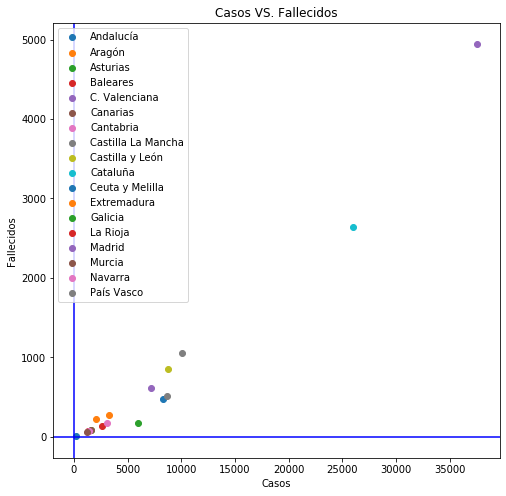

Total: Casos 130759
Total: Fallecidos 12418


,Lugar,Casos,Fallecidos
9,Ceuta y Melilla,166,4
14,Murcia,1235,59
3,Baleares,1293,75
5,Cantabria,1441,68
2,Asturias,1605,80
4,Canarias,1622,80
11,Extremadura,2047,218
17,La Rioja,2592,134
15,Navarra,3073,178
1,Aragón,3232,270


In [6]:
Comparar_Dos_Dimenciones(['Casos', 'Fallecidos'] )   

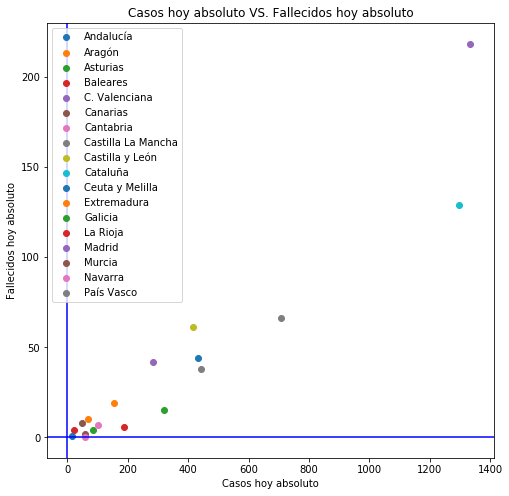

Total: Casos hoy absoluto 6023
Total: Fallecidos hoy absoluto 674


,Lugar,Casos hoy absoluto,Fallecidos hoy absoluto
9,Ceuta y Melilla,14,1
3,Baleares,22,4
14,Murcia,47,8
5,Cantabria,57,0
4,Canarias,58,2
11,Extremadura,68,10
2,Asturias,83,4
15,Navarra,101,7
1,Aragón,154,19
17,La Rioja,187,6


In [7]:
Comparar_Dos_Dimenciones(['Casos hoy absoluto', 'Fallecidos hoy absoluto'])

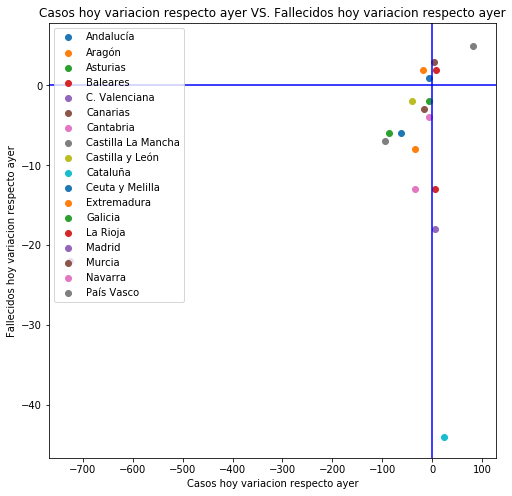

Total: Casos hoy variacion respecto ayer -1003
Total: Fallecidos hoy variacion respecto ayer -135


,Lugar,Casos hoy variacion respecto ayer,Fallecidos hoy variacion respecto ayer
13,Madrid,-726,-22
6,Castilla La Mancha,-94,-7
12,Galicia,-87,-6
0,Andalucía,-63,-6
7,Castilla y León,-40,-2
15,Navarra,-35,-13
1,Aragón,-35,-8
11,Extremadura,-18,2
4,Canarias,-16,-3
5,Cantabria,-6,-4


In [8]:
Comparar_Dos_Dimenciones(['Casos hoy variacion respecto ayer', 'Fallecidos hoy variacion respecto ayer'])

In [9]:
# Cargamos datos
import pandas as pd
import Loading_data 

from Loading_data import Get_Comunidades_List as comunidades
COMUNIDADES = comunidades()

def Get_Dimension_CCAA(Dimension):
    dimension_df = pd.DataFrame()
    for ca in COMUNIDADES: 
        df = Loading_data.Get_Comunidad(ca)
        df = df.sort_values(by='Fecha')
        df = df.reset_index() # Resets the index, makes factor a column    
        df = df[df["Casos"] >= 100]
        dimension_df[ca] = df[Dimension]
    return dimension_df 


In [10]:
from matplotlib import pyplot as plt    
from IPython.display import display, HTML
import pandas as pd

import numpy as np


def compare_charts_median(Dimension,df): 
    short_df = df.tail(1)
    short_df = short_df.T
    short_df.columns = [Dimension]
    short_df

    mean_y = short_df.median(axis=1)[0]
    mean_y= df.tail(1).T.median().values[0]
    x = short_df.index
    y = short_df[Dimension]

    plt.figure(figsize = (10, 5))
    plt.scatter(x, y, c= "red", alpha = 0.5)
    plt.title(Dimension + " by region")
    color = 'blue'
    plt.xticks(rotation=90)
    plt.axhline(mean_y, c = color, alpha = 0.5, lw = 1)
    plt.annotate('Median ' + Dimension+  ' is {}'.format(round(mean_y, 2)),
            xy=(12, mean_y),
            xycoords='data',
            xytext=(50, 50), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color = "k", alpha = 0.5),
            color = color)
    return

def compare_charts_time(Dimension,df):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    for ca in df.columns:
        plt.plot(df[ca])
    plt.legend(df.columns)
    fig.suptitle('Comparativa de: '+Dimension+', igualando los dias', fontsize=20)
    plt.show()
    return 

def Report_Location(Dimension):
    # Ger Data
    df = Get_Dimension_CCAA(Dimension)
    # Compare chart
    compare_charts_time(Dimension,df)
    # Compare median chart
    compare_charts_median(Dimension,df)
    
    with pd.option_context("display.max_rows", 1000):
        display(HTML(df.to_html()))
    return 


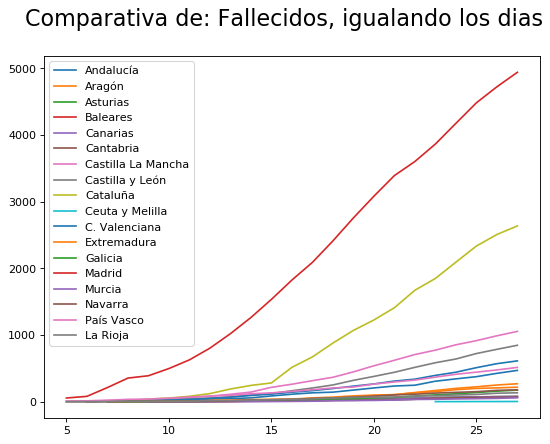

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0,NaN,NaN,NaN,NaN,NaN,1,NaN,4,NaN,NaN,NaN,NaN,56,NaN,NaN,11,2
6,0,NaN,NaN,NaN,NaN,NaN,5,1.0,4,NaN,NaN,NaN,NaN,81,NaN,0.0,14,2
7,7,11.0,1.0,NaN,1.0,NaN,17,9.0,12,NaN,5.0,2.0,2.0,213,NaN,1.0,23,4
8,11,12.0,1.0,NaN,2.0,NaN,17,12.0,18,NaN,13.0,3.0,3.0,355,NaN,2.0,36,5
9,19,13.0,1.0,1.0,3.0,NaN,28,22.0,41,NaN,22.0,6.0,3.0,390,0.0,3.0,40,5
10,23,15.0,1.0,2.0,3.0,NaN,42,29.0,55,NaN,24.0,8.0,4.0,498,0.0,4.0,53,5
11,30,17.0,2.0,2.0,4.0,1.0,62,43.0,82,NaN,33.0,10.0,5.0,628,0.0,5.0,71,7
12,40,22.0,5.0,4.0,7.0,2.0,84,55.0,122,NaN,50.0,12.0,9.0,804,1.0,9.0,85,15
13,47,24.0,8.0,4.0,9.0,5.0,112,74.0,191,NaN,69.0,14.0,12.0,1021,1.0,14.0,97,18
14,58,32.0,12.0,10.0,11.0,6.0,145,102.0,245,NaN,94.0,18.0,18.0,1263,2.0,24.0,120,22


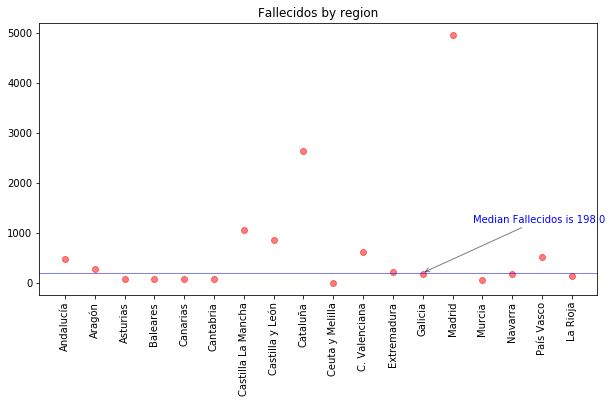

In [11]:
Report_Location("Fallecidos")

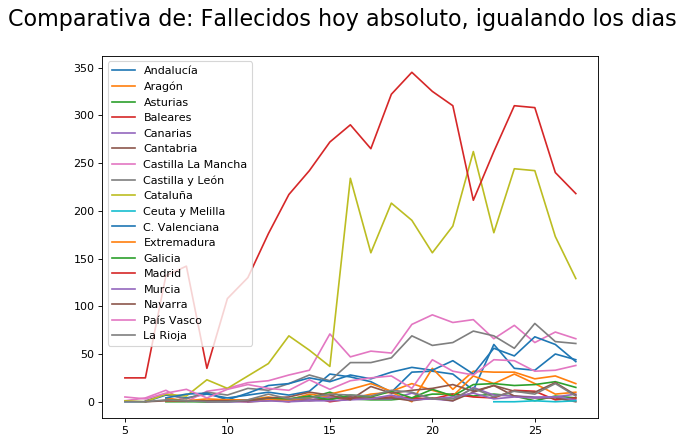

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,25,NaN,NaN,5,0
6,0,NaN,NaN,NaN,NaN,NaN,4,1.0,0,NaN,NaN,NaN,NaN,25,NaN,0.0,3,0
7,7,4.0,0.0,NaN,1.0,NaN,12,8.0,8,NaN,4.0,1.0,2.0,132,NaN,1.0,9,2
8,4,1.0,0.0,NaN,1.0,NaN,0,3.0,6,NaN,8.0,1.0,1.0,142,NaN,1.0,13,1
9,8,1.0,0.0,0.0,1.0,NaN,11,10.0,23,NaN,9.0,3.0,0.0,35,0.0,1.0,4,0
10,4,2.0,0.0,1.0,0.0,NaN,14,7.0,14,NaN,2.0,2.0,1.0,108,0.0,1.0,13,0
11,7,2.0,1.0,0.0,1.0,0.0,20,14.0,27,NaN,9.0,2.0,1.0,130,0.0,1.0,18,2
12,10,5.0,3.0,2.0,3.0,1.0,22,12.0,40,NaN,17.0,2.0,4.0,176,1.0,4.0,14,8
13,7,2.0,3.0,0.0,2.0,3.0,28,19.0,69,NaN,19.0,2.0,3.0,217,0.0,5.0,12,3
14,11,8.0,4.0,6.0,2.0,1.0,33,28.0,54,NaN,25.0,4.0,6.0,242,1.0,10.0,23,4


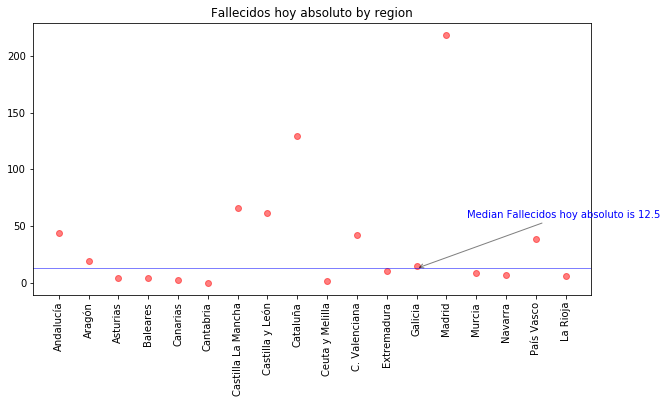

In [12]:
Report_Location("Fallecidos hoy absoluto") 

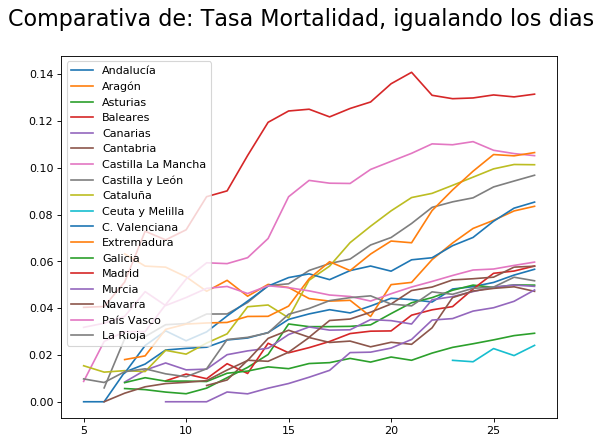

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0.000000,NaN,NaN,NaN,NaN,NaN,0.008696,NaN,0.015385,NaN,NaN,NaN,NaN,0.040346,NaN,NaN,0.031792,0.009756
6,0.000000,NaN,NaN,NaN,NaN,NaN,0.025773,0.005917,0.012658,NaN,NaN,NaN,NaN,0.040704,NaN,0.000000,0.033573,0.008230
7,0.012635,0.063218,0.005650,NaN,0.008403,NaN,0.029982,0.026946,0.013289,NaN,0.012225,0.018018,0.008163,0.051140,NaN,0.003650,0.036508,0.012821
8,0.016105,0.057971,0.005181,NaN,0.013514,NaN,0.029982,0.027842,0.012912,NaN,0.024030,0.019608,0.010274,0.072880,NaN,0.006390,0.047059,0.014085
9,0.022119,0.057522,0.004132,0.008929,0.016575,NaN,0.041481,0.032934,0.021972,NaN,0.030303,0.030928,0.008798,0.069186,0.000000,0.007772,0.041110,0.011933
10,0.022817,0.053381,0.003425,0.011834,0.013636,NaN,0.052434,0.033410,0.020355,NaN,0.026059,0.033195,0.008830,0.073484,0.000000,0.008299,0.044538,0.010684
11,0.023310,0.047222,0.005814,0.009852,0.013937,0.006944,0.059387,0.037489,0.025076,NaN,0.029864,0.033670,0.008651,0.087648,0.000000,0.009025,0.048464,0.014085
12,0.026403,0.051887,0.010288,0.016260,0.020115,0.009302,0.059030,0.037517,0.029027,NaN,0.036684,0.033898,0.012179,0.090124,0.004167,0.013554,0.049275,0.026596
13,0.027246,0.045113,0.014679,0.012085,0.021739,0.017730,0.061572,0.042431,0.040604,NaN,0.043017,0.036458,0.013115,0.105236,0.003378,0.017632,0.046257,0.027523
14,0.029577,0.050157,0.020202,0.025000,0.022869,0.017291,0.069779,0.049635,0.041350,NaN,0.049448,0.036511,0.014901,0.119433,0.005797,0.027088,0.049566,0.029451


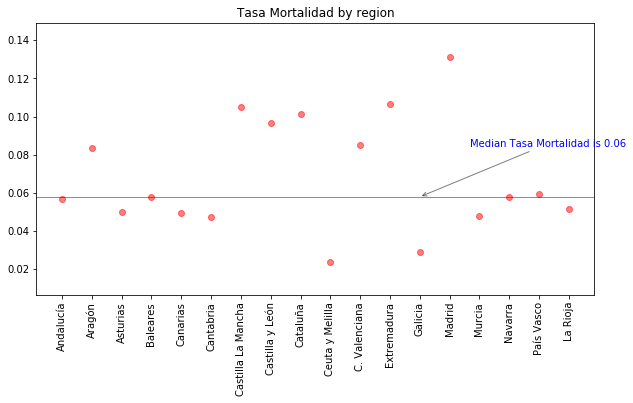

In [13]:
Report_Location("Tasa Mortalidad")

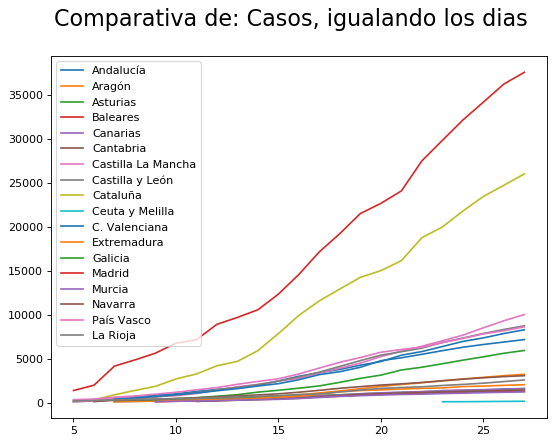

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,115,NaN,NaN,NaN,NaN,NaN,115,NaN,260,NaN,NaN,NaN,NaN,1388,NaN,NaN,346,205
6,219,NaN,NaN,NaN,NaN,NaN,194,169.0,316,NaN,NaN,NaN,NaN,1990,NaN,130.0,417,243
7,554,174.0,177.0,NaN,119.0,NaN,567,334.0,903,NaN,409.0,111.0,245.0,4165,NaN,274.0,630,312
8,683,207.0,193.0,NaN,148.0,NaN,567,431.0,1394,NaN,541.0,153.0,292.0,4871,NaN,313.0,765,355
9,859,226.0,242.0,112.0,181.0,NaN,675,668.0,1866,NaN,726.0,194.0,341.0,5637,122.0,386.0,973,419
10,1008,281.0,292.0,169.0,220.0,NaN,801,868.0,2702,NaN,921.0,241.0,453.0,6777,167.0,482.0,1190,468
11,1287,360.0,344.0,203.0,287.0,144.0,1044,1147.0,3270,NaN,1105.0,297.0,578.0,7165,204.0,554.0,1465,497
12,1515,424.0,486.0,246.0,348.0,215.0,1423,1466.0,4203,NaN,1363.0,354.0,739.0,8921,240.0,664.0,1725,564
13,1725,532.0,545.0,331.0,414.0,282.0,1819,1744.0,4704,NaN,1604.0,384.0,915.0,9702,296.0,794.0,2097,654
14,1961,638.0,594.0,400.0,481.0,347.0,2078,2055.0,5925,NaN,1901.0,493.0,1208.0,10575,345.0,886.0,2421,747


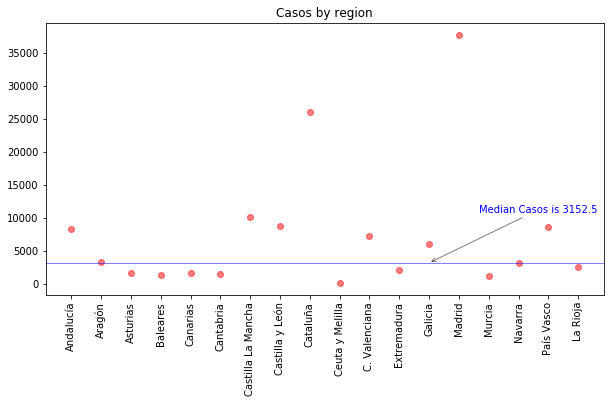

In [14]:
Report_Location("Casos") 

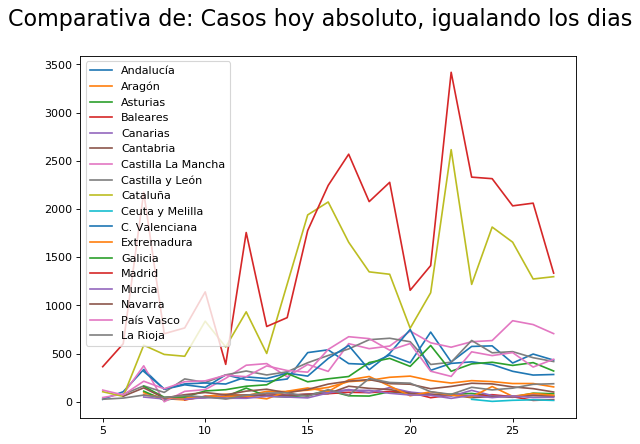

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,25,NaN,NaN,NaN,NaN,NaN,44,NaN,104,NaN,NaN,NaN,NaN,364,NaN,NaN,121,26
6,104,NaN,NaN,NaN,NaN,NaN,79,77.0,56,NaN,NaN,NaN,NaN,602,NaN,57.0,71,38
7,335,94.0,110.0,NaN,49.0,NaN,373,165.0,587,NaN,315.0,72.0,160.0,2175,NaN,144.0,213,69
8,129,33.0,16.0,NaN,29.0,NaN,0,97.0,491,NaN,132.0,42.0,47.0,706,NaN,39.0,135,43
9,176,19.0,49.0,20.0,33.0,NaN,108,237.0,472,NaN,185.0,41.0,49.0,766,25.0,73.0,208,64
10,149,55.0,50.0,57.0,39.0,NaN,126,200.0,836,NaN,195.0,47.0,112.0,1140,45.0,96.0,217,49
11,279,79.0,52.0,34.0,67.0,61.0,243,279.0,568,NaN,184.0,56.0,125.0,388,37.0,72.0,275,29
12,228,64.0,142.0,43.0,61.0,71.0,379,319.0,933,NaN,258.0,57.0,161.0,1756,36.0,110.0,260,67
13,210,108.0,59.0,85.0,66.0,67.0,396,278.0,501,NaN,241.0,30.0,176.0,781,56.0,130.0,372,90
14,236,106.0,49.0,69.0,67.0,65.0,259,311.0,1221,NaN,297.0,109.0,293.0,873,49.0,92.0,324,93


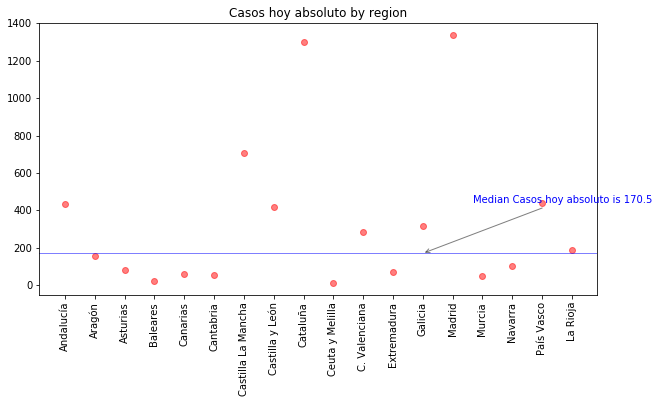

In [15]:
Report_Location("Casos hoy absoluto")

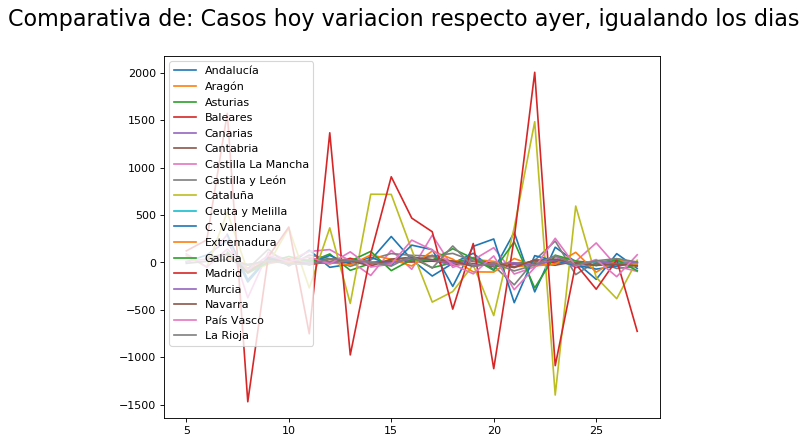

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,6,NaN,NaN,NaN,NaN,NaN,12,NaN,72,NaN,NaN,NaN,NaN,122,NaN,NaN,91,-9
6,79,NaN,NaN,NaN,NaN,NaN,35,56.0,-48,NaN,NaN,NaN,NaN,238,NaN,30.0,-50,12
7,231,78.0,90.0,NaN,30.0,NaN,294,88.0,531,NaN,297.0,52.0,110.0,1573,NaN,87.0,142,31
8,-206,-61.0,-94.0,NaN,-20.0,NaN,-373,-68.0,-96,NaN,-183.0,-30.0,-113.0,-1469,NaN,-105.0,-78,-26
9,47,-14.0,33.0,1.0,4.0,NaN,108,140.0,-19,NaN,53.0,-1.0,2.0,60,5.0,34.0,73,21
10,-27,36.0,1.0,37.0,6.0,NaN,18,-37.0,364,NaN,10.0,6.0,63.0,374,20.0,23.0,9,-15
11,130,24.0,2.0,-23.0,28.0,46.0,117,79.0,-268,NaN,-11.0,9.0,13.0,-752,-8.0,-24.0,58,-20
12,-51,-15.0,90.0,9.0,-6.0,10.0,136,40.0,365,NaN,74.0,1.0,36.0,1368,-1.0,38.0,-15,38
13,-18,44.0,-83.0,42.0,5.0,-4.0,17,-41.0,-432,NaN,-17.0,-27.0,15.0,-975,20.0,20.0,112,23
14,26,-2.0,-10.0,-16.0,1.0,-2.0,-137,33.0,720,NaN,56.0,79.0,117.0,92,-7.0,-38.0,-48,3


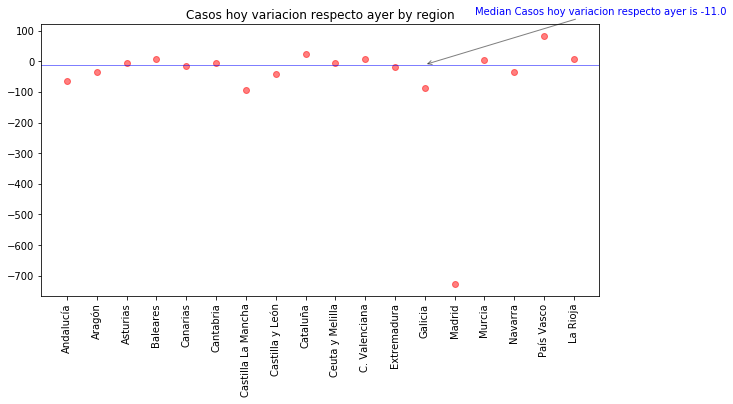

In [16]:
Report_Location("Casos hoy variacion respecto ayer")

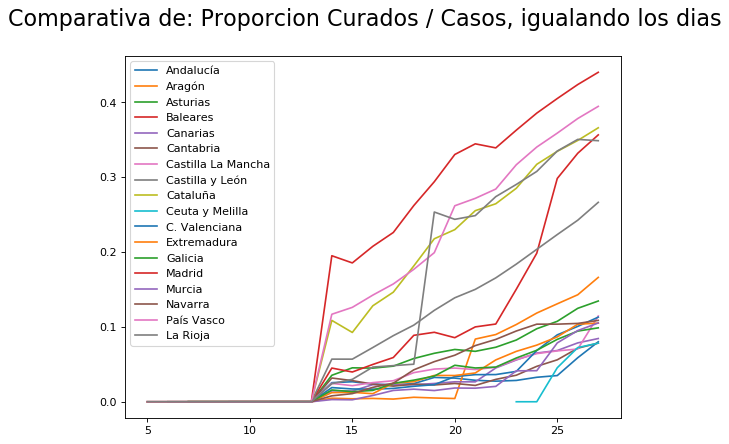

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
6,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.025497,0.004702,0.035354,0.045000,0.014553,0.031700,0.024543,0.056934,0.108692,NaN,0.018937,0.012170,0.015728,0.195083,0.002899,0.007901,0.116894,0.024096


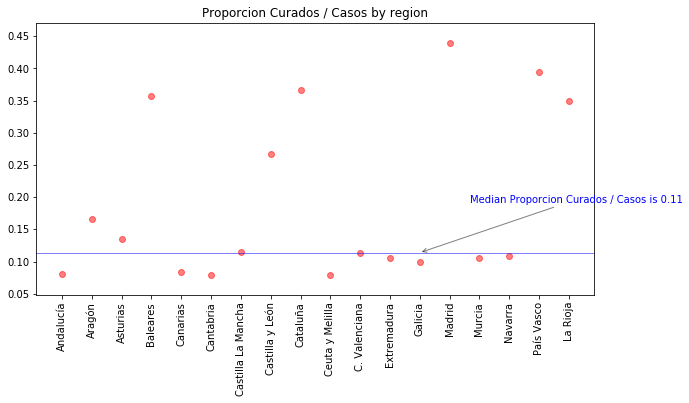

In [17]:
Report_Location("Proporcion Curados / Casos")

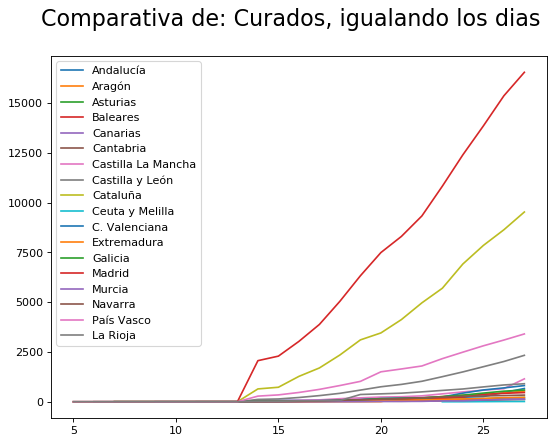

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla La Mancha,Castilla y León,Cataluña,Ceuta y Melilla,C. Valenciana,Extremadura,Galicia,Madrid,Murcia,Navarra,País Vasco,La Rioja
5,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,0,0
6,0,NaN,NaN,NaN,NaN,NaN,0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,0.0,0,0
7,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
8,0,0.0,0.0,NaN,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,NaN,0.0,0,0
9,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
10,0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
11,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
12,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
13,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,NaN,0.0,0.0,0.0,0,0.0,0.0,0,0
14,50,3.0,21.0,18.0,7.0,11.0,51,117.0,644,NaN,36.0,6.0,19.0,2063,1.0,7.0,283,18


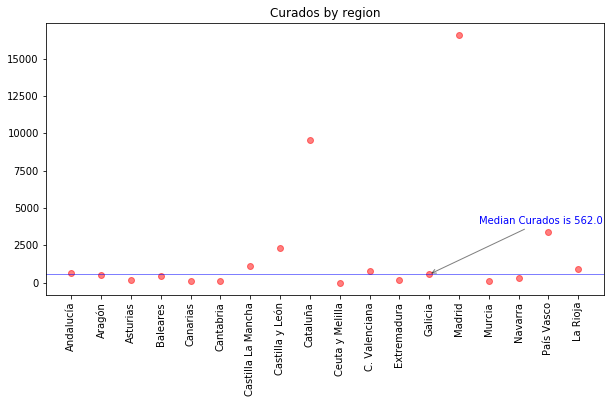

In [18]:
Report_Location("Curados")

## ¿Hemos alcanzado el pico de la curva?


### Casos totales españa, evolucion


,Total Fallecidos,Total Fallecidos hoy absoluto,MA Total Fallecidos hoy absoluto,Variacion MA Total Fallecidos hoy absoluto
5,74,NaN,NaN,NaN
6,107,33.0,NaN,NaN
7,308,201.0,NaN,NaN
8,490,182.0,NaN,NaN
9,597,107.0,130.75,NaN
10,766,169.0,164.75,34.00
11,1002,236.0,173.50,8.75
12,1326,324.0,209.00,35.50
13,1720,394.0,280.75,71.75
14,2182,462.0,354.00,73.25


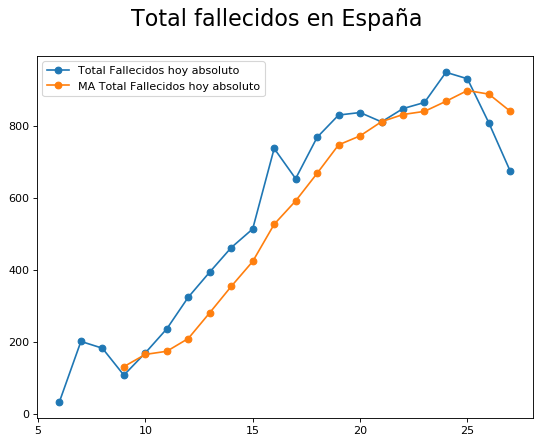

In [19]:
# Casos totales españa, evolucion
import Loading_data 

Dimension = 'Fallecidos'
df = Get_Dimension_CCAA(Dimension)

df['Total Fallecidos'] = df.sum(axis=1)
df['Total Fallecidos']

CONVERT_INT_COLUMNS = ['Total Fallecidos']
for column in CONVERT_INT_COLUMNS :
    df[column] = df[column].fillna(0)
    df[column] = df[column].astype(np.int64)
        
#df['MA variation']=  df['MA'] - df['MA'].shift(1)
df['Total Fallecidos hoy absoluto'] = df['Total Fallecidos'] - df['Total Fallecidos'].shift(1)
df['MA Total Fallecidos hoy absoluto'] = df['Total Fallecidos hoy absoluto'].rolling(window=4).mean()

df['Variacion MA Total Fallecidos hoy absoluto'] = df['MA Total Fallecidos hoy absoluto'] - df['MA Total Fallecidos hoy absoluto'].shift(1)

df_plt = df[['Total Fallecidos hoy absoluto','MA Total Fallecidos hoy absoluto']]
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.plot(df_plt, marker='o') 
plt.legend(df_plt.columns)
fig.suptitle( "Total fallecidos en España", fontsize=20)

df[['Total Fallecidos',
    'Total Fallecidos hoy absoluto',
    'MA Total Fallecidos hoy absoluto',
    'Variacion MA Total Fallecidos hoy absoluto']]


In [20]:
def report_single_location_single_dimension(location,dimension):
    MOVING_AVERAGE_WINDOW = 4
    Dimension = 'Fallecidos'

    df = pd.DataFrame()
    df[dimension] = Get_Dimension_CCAA(dimension)[location]
    df['Moving Average ' + dimension] = df[dimension].rolling(window=4).mean()

    display(HTML("<h2>Analisis de ''" + dimension +"'', en " + location + "</h2>"))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(df, marker='o') 
    plt.legend(df.columns)
    fig.suptitle( dimension + ' in ' + location, fontsize=20)

    display(HTML(pd.DataFrame(df).to_html()))
    return  


### Casos totales españa, evolucion


,Fallecidos hoy absoluto,Moving Average Fallecidos hoy absoluto
5,25,NaN
6,25,NaN
7,132,NaN
8,142,81.00
9,35,83.50
10,108,104.25
11,130,103.75
12,176,112.25
13,217,157.75
14,242,191.25


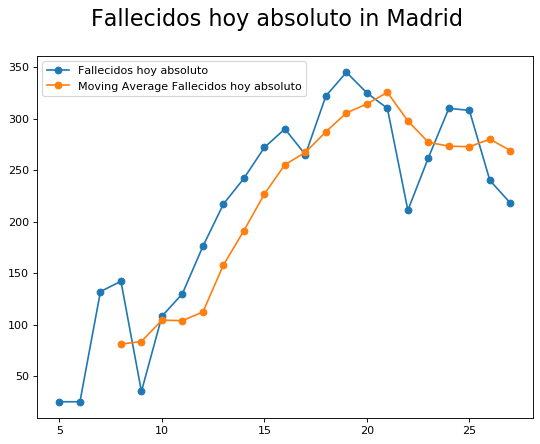

In [21]:

dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Madrid',dimension)

,Fallecidos hoy absoluto,Moving Average Fallecidos hoy absoluto
5,1,NaN
6,0,NaN
7,8,NaN
8,6,3.75
9,23,9.25
10,14,12.75
11,27,17.50
12,40,26.00
13,69,37.50
14,54,47.50


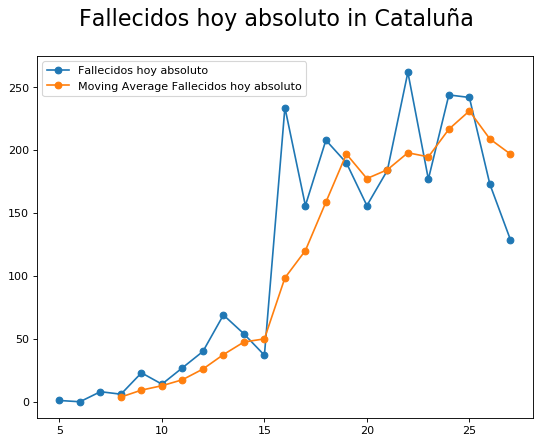

In [22]:

dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Cataluña',dimension)

,Fallecidos hoy absoluto,Moving Average Fallecidos hoy absoluto
5,1,NaN
6,4,NaN
7,12,NaN
8,0,4.25
9,11,6.75
10,14,9.25
11,20,11.25
12,22,16.75
13,28,21.00
14,33,25.75


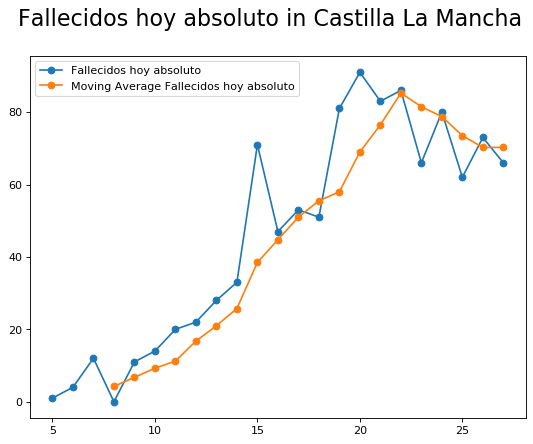

In [24]:
dimension = 'Fallecidos hoy absoluto'
report_single_location_single_dimension('Castilla La Mancha',dimension)